In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [15]:
import numpy as np
from matplotlib import pyplot as plt

In [16]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 974 files belonging to 2 classes.


In [17]:
import cv2
import imghdr

In [18]:
data_iterator = data.as_numpy_iterator()

In [19]:
#Gets another batch of 32 images and labels
batch = data_iterator.next()

In [20]:
#Labels for images
batch[1].shape

(32,)

In [21]:
#Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

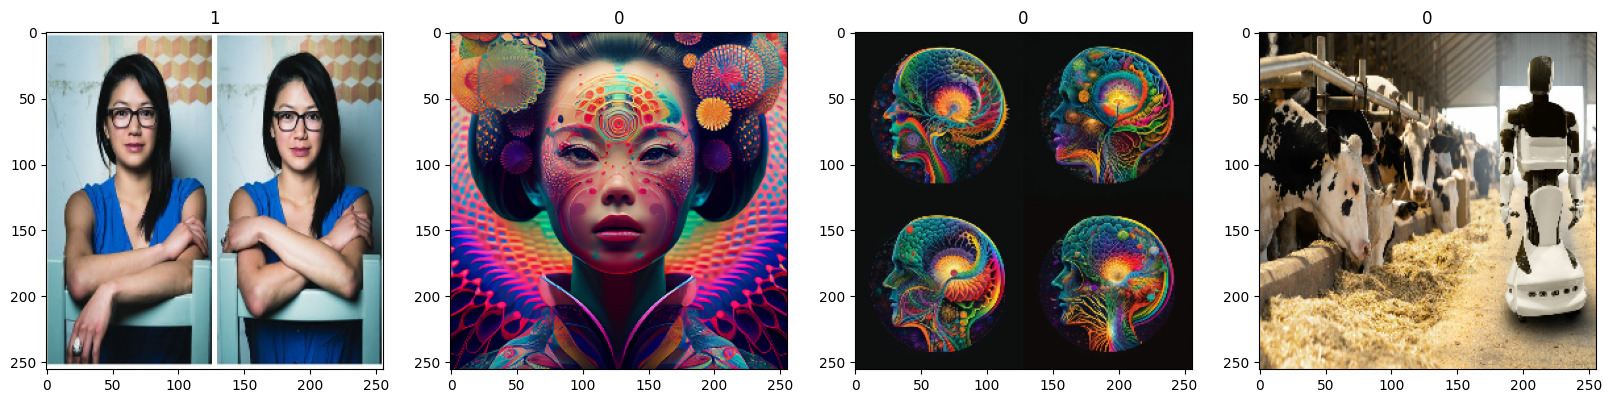

In [22]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx]) 

#Class 1 = AI
#Class 0 = Real

In [23]:
data = data.map(lambda x,y: (x/255, y))
len(data)

31

In [24]:
train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [28]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape= (256,256,3)))
model.add(MaxPooling2D())
#model.add(Dropout(0.10))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(1, activation = 'sigmoid'))

c:\Users\krist\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [29]:
model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#One Epoch is a complete iteration of the entire dataset. During each epoch, the cnn updates its weights and biases.
epochs = 100  
#Batch size is the number of training examples the cnn processes at oncee before updating its weights.
batch_size = 250

In [ ]:
# Data augmentation is used in CNN's to increase the amount and diversity of the training data without actually collecting new data.
# It is done by applying a variety of transformations to existing training data, such as rotation, scaling, flipping, and cropping
# Done to create new versions of the same image
# Beneficial since it improves performance and generalization of CNN's by increasing diversity and amount of training data
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=5,  #Range from 0-180 degrees which to randomly rotate pictures. 
        zoom_range = 0.1, #Randomly zoom into pictures
        width_shift_range=0.1,  #Randomly translates image from 0-10% width direction
        height_shift_range=0.1,  #Randomly translates image from 0-10% height direction
        horizontal_flip=False,  #Don't flip image (probably since we are dealing with integers)
        vertical_flip=False)  

datagen.fit(X_train)

In [31]:
#Logger resultatene
from tensorflow.keras.callbacks import EarlyStopping
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=6)

my_callbacks = [
    tensorboard_callback,
    early_stopping
]
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val, y_val), steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=my_callbacks)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 641ms/step - accuracy: 0.4686 - loss: 1.7831 - val_accuracy: 0.5573 - val_loss: 0.6790
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 609ms/step - accuracy: 0.5803 - loss: 0.6820 - val_accuracy: 0.5573 - val_loss: 0.6890
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 617ms/step - accuracy: 0.5581 - loss: 0.6788 - val_accuracy: 0.5729 - val_loss: 0.6647
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 613ms/step - accuracy: 0.6084 - loss: 0.6405 - val_accuracy: 0.5469 - val_loss: 0.6625
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 610ms/step - accuracy: 0.5974 - loss: 0.6364 - val_accuracy: 0.6771 - val_loss: 0.6398
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 633ms/step - accuracy: 0.6422 - loss: 0.6119 - val_accuracy: 0.6094 - val_loss: 0.6543
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 612ms/step - accuracy: 0.6773 - loss: 0.5765 - val_accuracy: 0.6875 - val_loss: 0.6118
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 645ms/step - accuracy: 0.7889 - loss: 0.5127 - 

In [33]:
hist.history

{'accuracy': [0.484375,
  0.5482954382896423,
  0.5582386255264282,
  0.5866477489471436,
  0.6292613744735718,
  0.6363636255264282,
  0.6690340638160706,
  0.7457386255264282,
  0.7911931872367859,
  0.8309659361839294,
  0.8678977489471436,
  0.9090909361839294,
  0.9275568127632141,
  0.953125,
  0.96875,
  0.96875,
  0.984375,
  0.9715909361839294,
  0.9786931872367859,
  0.9829545617103577,
  0.9971590638160706,
  0.9971590638160706,
  0.9900568127632141,
  0.9928977489471436,
  0.9985795617103577,
  0.9971590638160706,
  0.9985795617103577,
  0.9943181872367859,
  0.9971590638160706,
  0.9985795617103577,
  0.9957386255264282,
  0.9957386255264282,
  0.9971590638160706,
  0.9943181872367859,
  0.9957386255264282,
  0.9943181872367859,
  0.9872159361839294,
  0.9971590638160706,
  0.9971590638160706,
  0.9985795617103577,
  0.9985795617103577,
  0.9957386255264282,
  1.0,
  1.0,
  0.9985795617103577,
  1.0,
  1.0,
  0.9957386255264282,
  0.9957386255264282,
  0.9957386255264282,


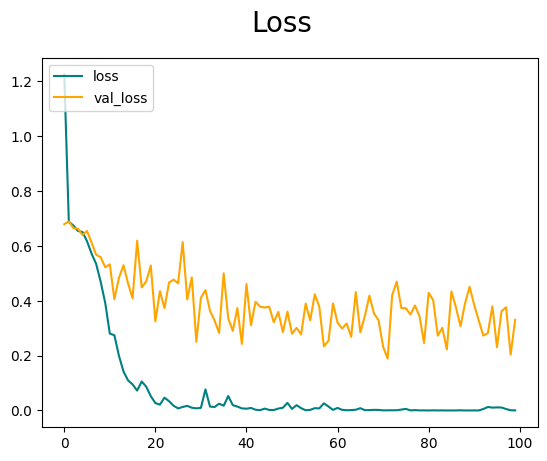

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

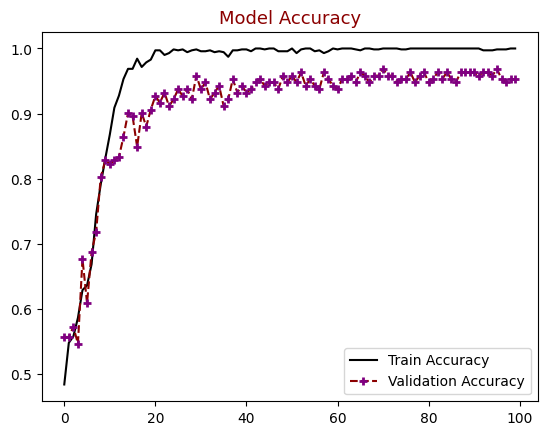

In [35]:
# Model Accuracy 
import matplotlib 
plt.figure()
plt.plot(hist.history["accuracy"],label = "Train Accuracy", color = "black")
plt.plot(hist.history["val_accuracy"],label = "Validation Accuracy", color = "darkred", marker = "+", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Accuracy", color = "darkred", size = 13)
plt.legend()
plt.show()

In [36]:


# We make predictions using the model we have created.
Y_pred = model.predict(X_val)
# argmax = To briefly mention it, it will give the index of the value with the highest value.
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# We do the same for the y_val values. because we will compare these values. 
Y_true = np.argmax(y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label", color = "blue")
plt.ylabel("True Label", color = "green")
plt.title("Confusion Matrix", color = "darkred", size = 15)
plt.show()

NameError: name 'X_val' is not defined